# LangGraph 단계별 스트리밍 출력
이번에는 LangGrpah 의 stream() 출력 함수에 대한 조금 더 자세한 설명을 진행한다.

LangGraph 의 스트리밍 출력 함수는 그래프의 각 단계를 스트리밍하는 기능을 제공한다.

참고: 아래의 LangGraph 예제는 이전 섹션의 예제와 동일하다.

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

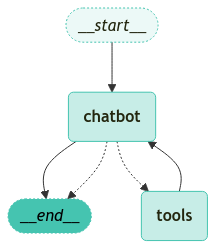

In [1]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data",  # 테스트를 위하여 더미 데이터를 추가합니다.
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile()

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

## StateGraph의 stream() 함수
`stream` 메서드는 단일 입력에 대한 그래프 단계를 스트리밍하는 기능을 제공한다.

### 매개변수
- `input`(Union[dict[str, Any], Any]) : 그래프에 대한 입력
- `config` (Optional[RunnableConfig]) : 실행 구성
- `stream_mode`(Optional[Union[StremaMode, list[str]]]) : 출력 스트리밍 모드
- `output_keys` (Optional[Union[str, Sequence[str]]]) : 스트리밍할 키
- `interrupt_before` (Optional[Union[All, Sequence[str]]]) : 실행 전 중단할 노드
- `inerrupt_after` (Optional[Union[All, Sequence[str]]]) : 실행 후 중단할 노드
- `debug` (Optional[bool]) : 디버그 정보 출력 여부
- `subgraphs` (bool): 서브 그래프 스트리밍 모드

### 반환값
- literator[Union[dict[str,Any], Any]]: 단계별 출력 값을 반환하는 이터레이터. 출력형태는 `stream_mode`에 따라 다름

### 주요 기능
1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리
2. 다양한 스트리밍 모드 지원(values, updates, debug)
3. 콜백 관리 및 오류 처리
4. 재귀 제한 및 중단 조건 처리

### 스트리밍 모드
- `values`: 단계별 현재 상태 값 출력을 반환
- `updates`: 각 단계의 상태 업데이트만 출력
- `debug`: 각 단계의 디버그 이벤트 출력


In [4]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)

`config` 를 설정하고 스트리밍 출력을 진행한다


In [ ]:
for event in graph.stream(input=input, config = config):
    for key, value in event.items():
        print(f"\n[ {key}]\n")
        # value에 messages 키가 존재하는 경우 메시지 출력
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력
            value["messages"][-1].pretty_print()

## output_keys 매개변수
`output_keys` 매개변수는 스트리밍 출력에서 특정 키만 출력하도록 지정할 때 사용한다.

list 형식으로만 지정할 수 있으며, channels에 정의된 키 중 하나여야 한다.

### tip
- 매 단계 마다 출력되는 State key가 많은 경우 일부만 스트리밍 하고 싶은 경우에 유용

In [6]:
# channels 에 정의된 키 목록 출력
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:chatbot', 'branch:chatbot:tools_condition:tools']


In [13]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 state 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

#config 설정
config = RunnableConfig(
    recursion_limit=10, # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"}, # 스레드 ID 설정
    tags=["my-tag"], # Tag
)

# 스트리밍 출력 진행
for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data", "messages"]
):
    for key, value in event.items():
        # key는 노드이름
        print(f"\n[ {key} ]\n")

        # dummy_data 키가 존재하는 경우 출력
        if value:
            print(value.keys())
            # dummy_data key가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])
            if "messages" in value:
                print(value["messages"])
                # print(value["messages"])


[ chatbot ]

dict_keys(['messages', 'dummy_data'])
[chatbot] 호출, dummy data
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wAsz7l9QWVPGxDgf8ju6SB9I', 'function': {'arguments': '{"query":"2024년 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 57, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-904226b0-bbc6-4a11-875a-58ef9084d0a1-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'call_wAsz7l9QWVPGxDgf8ju6SB9I', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 22, 'total_tokens': 79, 'input_

In [14]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # messages 만 출력
):
    for key, value in event.items():
        # messages 가 존재하는 경우
        if value and "messages" in value:
            # key 는 노드 이름
            print(f"\n[ {key} ]\n")
            # messages 의 마지막 요소의 content 를 출력합니다.
            print(value["messages"][-1].content)


[ chatbot ]



[ tools ]

[{"url": "https://news.google.com/rss/articles/CBMiaEFVX3lxTE4xVV96b1c5cjZNWHl5VFd3aGZkcDNoSDN0Vmp6a3RNVVl2VG1FOW96RTFOUnpBYkR2OEx3VGRsS3RaQTdvQ3FkcmFRQmd5UmtMd1labGFQS2J6YmpKZ1p4S2xXTUVXQjVS0gFsQVVfeXFMTlctOUd6VTVQRXF6dWpTNnJ2S1d1dndJdGFGN2I1Yjl1bEhVNU03UmpSNUtONFZZZ045bmNZMGgxX3NlQjJydGwzUnpwamR6V0hSTWVFbEVKWVA5b3JxQ1NQWmNfVXRhR1AyZ2lG?oc=5", "content": "2024 노벨문학상의 주인공, ‘한강’의 대표 문장 6 - Den"}, {"url": "https://news.google.com/rss/articles/CBMibkFVX3lxTE43MFo5Z2Q4UGNUZnAtMjhYeXNqNk1rbl9lYXRWdTFRX1Z0R3RqLWlqSk1LWVRrRjl6bFFVVEg2VEMtc09YUW5jeEVyVFIxM05ZeDRnUUo2Sjcwd1lvWGFicFVzSHNZSGpZbU05MEFR?oc=5", "content": "파격만이 가득한 2024 노벨상 수상을 돌아보며 - 포항공대신문"}, {"url": "https://news.google.com/rss/articles/CBMiWkFVX3lxTE1yZWFtV0RjcjNLc2szQ2czX2ZnSU5sTGFocm8wNVNfX0JkTG0tRVBVUkZmWmFKRGVLNW9zMGtFeWZncmpRNGxRVnVzR3ZubmxaT1ZSNy1CNmZiQdIBXEFVX3lxTFB5YlhvcDVQRDJwYVh4TExzNE5XbHBRWm5JTGVROU5tcTEyMVZUejRtODYybUtsdVdKUGtXcExyenpfQnRxM3JjakxuSWxjY0lnd1YyUktBUW5pV0J2?oc=5", "content": 

## stream_mode 옵션
`stream_mode` 옵션은 스트리밍 출력 모드를 지정하는 데 사용됩니다.

- `values`: 각 단계의 현재 상태 값 출력
- `updates`: 각 단계의 상태 업데이트만 출력 (기본값)

`stream_mode = "values"`
`values` 모드는 각 단계의 현재 상태 값을 출력합니다.

참고

`event.items()`

- `key`: State 의 key 값
- `value`: State 의 key 에 대한하는 value

In [15]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # 기본값
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)


[ messages ]

메시지 개수: 1

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 2

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 3

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 4

[ dummy_data ]

==============================  단계  ==============================



`stream_mode = "updates"`
`updates` 모드는 각 단계에 대한 업데이트된 `State` 만 내보냅니다.

출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 `dictionary` 입니다.
참고

`event.items()`

`key`: 노드(Node) 의 이름
`value`: 해당 노드(Node) 단계에서의 출력 값(dictionary). 즉, 여러 개의 key-value 쌍을 가진 dictionary 입니다.

In [16]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # 기본값
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # value 는 노드의 출력값
        print(value.keys())

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)


[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================

[ tools ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================


### interrupt_before 와 interrupt_after 옵션
interrupt_before 와 interrupt_after 옵션은 스트리밍 중단 시점을 지정하는 데 사용됩니다.

interrupt_before: 지정된 노드 이전에 스트리밍 중단
interrupt_after: 지정된 노드 이후에 스트리밍 중단

In [17]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)


[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NZde8Kdk7fMS2UHtzHbKCYGm', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature news"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f562b29-8fa3-4a70-9e0d-792e91408f6a-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature news'}, 'id': 'call_NZde8Kdk7fMS2UHtzHbKCYGm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 21, 'total_t

In [18]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pkZjEuXPQxIhjspOr8xP8LFp', 'function': {'arguments': '{"query":"2024 Nobel Literature Prize"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 57, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-693dddd8-5bfc-43d7-bbcb-f55bbfba2777-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Literature Prize'}, 'id': 'call_pkZjEuXPQxIhjspOr8xP8LFp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 19, 'total_tokens': 76